## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [184]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [185]:
# Opening JSON file 
f = open('complaints.json','r')    # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [186]:
# Inspect the dataframe to understand the given data.

df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided
78312,complaint-public-v2,complaint,2001189,0.0,None,None,2001189,Payment to acct not credited,2016-07-06T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-07-07T12:00:00-05:00,None,None,Yes,Roughly 10+ years ago I closed out my accounts...,None,Consent provided


In [187]:
# Printing the column names

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [188]:
# Assiging new column names

for column in df.columns:
  string = ""
  for i in range (0,len(column)):
    if column[i] == "_":
      continue
    else:
      string += column[i]
  df.rename(columns = {column:string}, inplace = True)

df.columns

Index(['index', 'type', 'id', 'score', 'source.tags', 'source.zipcode',
       'source.complaintid', 'source.issue', 'source.datereceived',
       'source.state', 'source.consumerdisputed', 'source.product',
       'source.companyresponse', 'source.company', 'source.submittedvia',
       'source.datesenttocompany', 'source.companypublicresponse',
       'source.subproduct', 'source.timely', 'source.complaintwhathappened',
       'source.subissue', 'source.consumerconsentprovided'],
      dtype='object')

In [189]:
# Extracting the actual column name

for column in df.columns:
  string = ""
  src = ""
  #print((column))
  #print(len(column))
  if len(column) > 6:
    for i in range (0,6):
      src += column[i]
    #print(src)
  if src == "source":
    df.rename(columns = {column:column[7:]}, inplace = True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely',
       'complaintwhathappened', 'subissue', 'consumerconsentprovided'],
      dtype='object')

In [190]:
# Renaming the column "complaintwhathappened" as "complaints"

df.rename(columns = {"complaintwhathappened":"complaints"}, inplace = True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [191]:
# Printing the sum of blank value present in every columns in the dataframe

(df[:] == "").sum()

index                          0
type                           0
id                             0
score                          0
tags                           0
zipcode                        0
complaintid                    0
issue                          0
datereceived                   0
state                          0
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse          0
subproduct                     0
timely                         0
complaints                 57241
subissue                       0
consumerconsentprovided        0
dtype: int64

In [192]:
# Assiging nan in place of blanks in the complaints column

df["complaints"].replace(r'^\s*$', np.nan, regex=True, inplace = True)

In [193]:
# Printing sum of blank value after "NaN" replacement

(df[:] == "").sum()

index                      0
type                       0
id                         0
score                      0
tags                       0
zipcode                    0
complaintid                0
issue                      0
datereceived               0
state                      0
consumerdisputed           0
product                    0
companyresponse            0
company                    0
submittedvia               0
datesenttocompany          0
companypublicresponse      0
subproduct                 0
timely                     0
complaints                 0
subissue                   0
consumerconsentprovided    0
dtype: int64

In [194]:
# Removing all rows where complaints column is NaN

df.dropna(inplace = True, subset=["complaints"])

In [195]:
# Finding count of NaN value in other columns

df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       17256
zipcode                     4645
complaintid                    0
issue                          0
datereceived                   0
state                        143
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      21070
subproduct                  2109
timely                         0
complaints                     0
subissue                    8176
consumerconsentprovided        0
dtype: int64

In [196]:
# Printing shape 

df.shape

(21072, 22)

In [197]:
# Printing the content of "complaints" column

df["complaints"]

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaints, Length: 21072, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [198]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
  text = text.lower()                 # Making the text lowercase
  text = re.sub(r'\[|\]',"",text)     # Removing text in square brackets 
  text = re.sub(r'[^\w\s]',"",text)   # Removing punctuation
  text = re.sub(r'\w*\d\w*',"",text)  # Removing words containing numbers
  return " ".join(text.split())       # Removing unwanted empty spaces

df['complaints'] = df['complaints'].apply(lambda text: clean_text(text))


In [199]:
# Creating a list containing all the contents of "complaints" cloumn/feature 

complaint_list = df.complaints.tolist()

# Printing 3 "complaints" after cleaning text

for i in range (0,3):
    print(complaint_list[i])
    print("\n")

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help


i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me


chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identit

In [200]:
# Writting function to Lemmatize the texts

stop_words = stopwords.words("english")

# call preprocess function to create lemmatization list using complaint list
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    
    words = word_tokenize(sentence)    # Tokenize into words
    
    words = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in words if word not in stop_words]
    
    document = " ".join(words)         # join words to make sentence
    
    return document


In [201]:
# Lematizing the complaint_list 

lemma_list = [lemmatize_sentence(sentence) for sentence in complaint_list]

# print couple of sentences from lemmatize list

lemma_list[:3]

['good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help',
 'upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled',
 'chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant']

In [202]:
# Creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(list(zip(complaint_list, lemma_list)), columns =['complaints', 'lemmatized_Complaints'])

# printing head 

df_clean.head()

,complaints,lemmatized_Complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...


In [203]:
# Writting a function to extract the POS tags 

# Creating an object of Spacy pretained model

nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])

def pos_tag(text):
    
    words = ""
       
    tagged_sentence = nlp(text)
    
    for token in tagged_sentence:
        if token.pos_ == "NOUN":
            words += token.text + " " 
    
    return words

In [204]:
# Importing swifter package to vectorise the application of a function on all the data present in 'lemmatized_Complaints' columns

#!pip install swifter

import swifter

In [205]:
# Applying POS tagging on 'lemmatized_Complaints' columns and saving it to a new column in the dataframe

df_clean['complaint_POS_removed'] =  df_clean['lemmatized_Complaints'].swifter.apply(pos_tag)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [206]:
# Printing first value of "lemmatized_Complaints" columns to check the difference after POS tagging

df_clean["lemmatized_Complaints"].iloc[0]

'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

In [207]:
# Printing first value of "complaint_POS_removed" columns to check the difference after POS tagging

df_clean["complaint_POS_removed"].iloc[0]

'morning name stop chase debt verification statement bank debt mail month debt information consumer chase account thanks advance help '

In [208]:
# Checking the clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...
...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




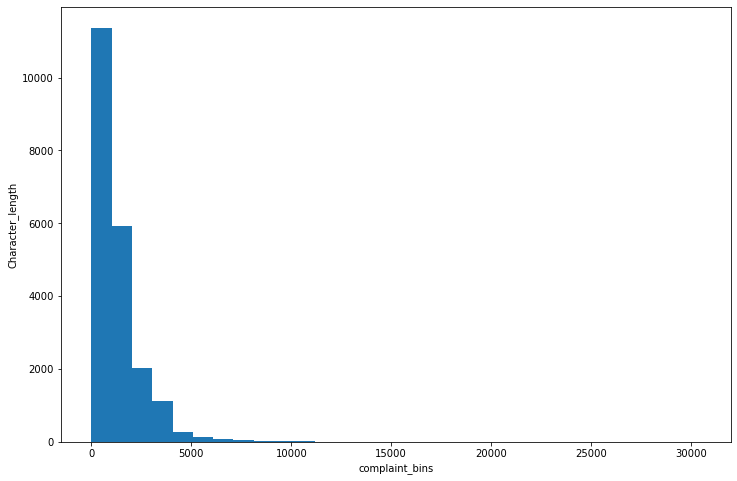

In [209]:
# Writting code to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(12,8))
doc_lens = [len(sent) for sent in df_clean.complaints]
plt.hist(doc_lens, bins = 30)
plt.xlabel('complaint_bins')
plt.ylabel('Character_length');

In [210]:
#!pip install WordCloud

#### Find the top 40 words by frequency among all the articles after processing the text.

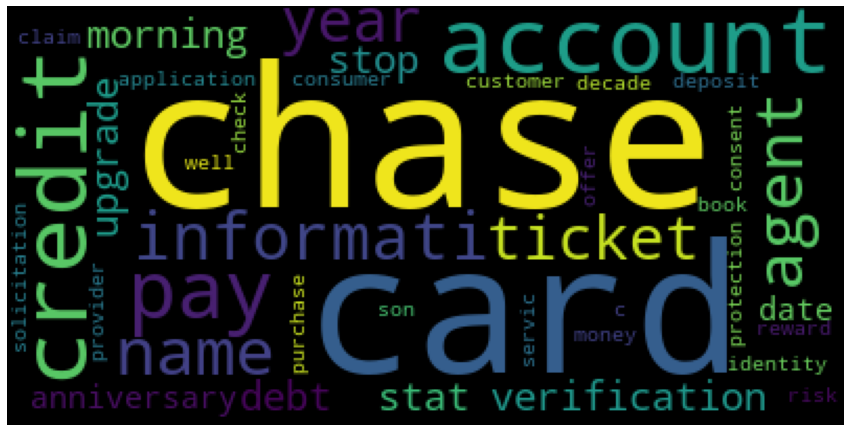

In [211]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_POS_removed))
plt.figure(figsize=(15,9))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [212]:
# Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [213]:
# Writting code to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_unigrams(text, n=None):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [214]:
# Printing the top 10 words in the unigram frequency

common_words = get_top_unigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram.head(10)

,unigram,count
0,chase,59476
1,account,42390
2,credit,31732
3,card,29360
4,payment,20598
5,time,15501
6,bank,13795
7,charge,12449
8,day,12116
9,money,11828


In [215]:
# Writting code to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean)

def get_top_bigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [216]:
# Printing the top 10 words in the bigram frequency 

common_words = get_top_bigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
bigram.head(10)

,bigram,count
0,credit card,12239
1,credit report,3624
2,account chase,3398
3,chase credit,3393
4,customer service,2787
5,chase account,2662
6,chase bank,2619
7,account account,2497
8,card chase,2121
9,checking account,1994


In [217]:
# Writting code to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_top_trigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [218]:
# Printing the top 10 words in the trigram frequency

common_words = get_top_trigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigram.head(10)

,trigram,count
0,chase credit card,2291
1,credit card account,1068
2,credit card company,970
3,credit card chase,963
4,chase customer service,574
5,credit card credit,538
6,inquiry credit report,506
7,card credit card,410
8,account credit card,406
9,charge credit card,394


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [219]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [220]:
# Printing dataframe after all masked texts has been removed

df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [221]:
# Writing code to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [222]:
# Writting code to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [223]:
# Importing NMF from sklearn

from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [224]:
#Loading nmf_model with the n_components i.e 5

num_topics = 5 

# Keeping the random_state =40

nmf_model = NMF(n_components=num_topics, random_state=40) 

nmf_model.fit(dtm)

print(len(tfidf.get_feature_names()))

6400


In [225]:
# Creating Document-topic matrix

W1 = nmf_model.fit_transform(dtm)

# Creating Topic-term matrix

H1 = nmf_model.components_

In [226]:
# Printing the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H1[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,chase,bank,fund,deposit,day,branch,transaction,checking,number,business,claim,fee
Topic 2,card,charge,chase,credit,dispute,purchase,transaction,fee,service,merchant,fraud,time,balance,company,customer
Topic 3,payment,balance,fee,month,statement,day,chase,date,time,pay,auto,credit,error,year,mortgage
Topic 4,credit,report,inquiry,card,account,score,debt,company,bureau,reporting,information,identity,application,limit,theft
Topic 5,loan,mortgage,chase,modification,home,property,year,letter,document,rate,time,foreclosure,sale,information,debt


In [227]:
# Assigning different index(Topic) to Topic-term matrix

H1 = pd.DataFrame(H1, index=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'], columns=tfidf.get_feature_names())
H1

,aaaratings,aarp,aba,abatement,abbreviation,aberrant,abhorrent,abide,ability,absence,...,yesterday,yhe,yield,yoga,youth,yr,zilch,zip,zombie,zone
Topic 1,0.000000,0.000000,0.001142,0.000000,0.000000,0.000000,0.000000,0.000916,0.029380,0.001842,...,0.061125,0.000303,0.003507,0.000000,0.000786,0.000000,0.000847,0.000000,0.000000,0.000753
Topic 2,0.000000,0.015620,0.000097,0.000000,0.000000,0.001783,0.002381,0.004588,0.013577,0.000000,...,0.031559,0.000804,0.000645,0.000713,0.000000,0.001888,0.000000,0.003919,0.000000,0.001753
Topic 3,0.000000,0.000357,0.000000,0.000672,0.000000,0.000000,0.000000,0.000239,0.022084,0.003494,...,0.010167,0.000000,0.000000,0.000013,0.000000,0.005640,0.000253,0.004747,0.000000,0.003469
Topic 4,0.000000,0.000576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031422,0.002989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.002803,0.001513,0.000000
Topic 5,0.000924,0.000000,0.000000,0.001250,0.000697,0.000000,0.000000,0.002718,0.035742,0.001152,...,0.015752,0.000119,0.001610,0.000036,0.000037,0.005337,0.000102,0.001291,0.000831,0.003235


In [228]:
# Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4

document_topic = pd.DataFrame(W1, columns = [f'Topic {i + 1}' for i in range(num_topics)])
document_topic["Dominant_Topic"] = document_topic.apply(lambda x : np.argmax(x), axis = 1)
document_topic.head()


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Dominant_Topic
0,0.020872,0.004850,0.008684,0.015800,0.027183,4
1,0.010449,0.001468,0.000934,0.003215,0.004212,0
2,0.000025,0.026918,0.000000,0.031247,0.003522,3
3,0.015989,0.021798,0.000086,0.048445,0.019407,3
4,0.061069,0.000849,0.000000,0.000000,0.006378,0


In [229]:
#Assiging the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = document_topic["Dominant_Topic"] 

In [230]:
df_clean.head()

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,4
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,3
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0


In [231]:
# Printing the shape of dataframe

df_clean.shape

(21072, 5)

In [232]:
# Printing the first 5 Complaint for each of the Topics

df_clean.groupby('Topic').head(5).sort_values(by = "Topic")

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code term account deposit bonus day de...,account code term account deposit bonus day de...,0
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto,account chase auto,0
21,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company time share company refund cred...,citizen company time share company refund cred...,1
19,i made a purchase with xxxx xxxx xxxx on in th...,made purchase xxxx xxxx xxxx amount charged tw...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
8,on xxxx i made a payment to an online retailer...,xxxx made payment online retailer using chase ...,payment retailer chase pay website scam websit...,payment retailer chase pay website scam websit...,1
16,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,love seat table chair debit card bank claim fu...,love seat table chair debit card bank claim fu...,1
14,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,amazon card catering order brother funeral amo...,amazon card catering order brother funeral amo...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [233]:
# Creating the dictionary of Topic names and Topics

Topic_names = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [234]:
# Printing dataframe after updating Topic

df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,Bank Account services
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,Others
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,Others
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...,Credit card/Prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card/Prepaid card
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...,Others
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [235]:
# Creating the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0,
               "Credit card/Prepaid card":1,
               "Mortgage/Loan":2,
               "Others":3,
               "Theft/Dispute Reporting":4 }

#Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [236]:
# Printing dataframe after updating Topic

df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,4
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,3
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...,3
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,2


In [237]:
# Keeping the columns"complaints" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[["complaints","Topic"]]

In [238]:
# Checking the content of new "training_data" dataframe

training_data

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in and was told b...,0
2,chase card was reported on however fraudulent ...,3
3,on while trying to book a xxxx xxxx ticket i c...,3
4,my grand son give me check for i deposit it in...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,1
21069,i am not familiar with xxxx pay and did not un...,3
21070,i have had flawless credit for yrs ive had cha...,2


In [239]:
# Checking shape of training_data dataframe

training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [240]:
# Importing necesarry package and methods

import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [241]:
# Shape before split

training_data.shape

(21072, 2)

In [242]:
# Performing Train-Test split

X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaints, training_data.Topic , train_size=0.8, random_state=40)

In [243]:
#Get the Vector count

count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [244]:
# Checking shape after split

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16857, 30069) (16857,)
(4215, 30069) (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [245]:
# Importing differnt methods

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import metrics


In [246]:
# For y_test and y__test_pred displaying the Classification Metrics

def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*22+"Classification Report"+'*'*22)
        print(classification_report(y_test,y_test_pred))

In [247]:
# Training models and testing on a test set.


def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    # Declaring global variable to save the value of fi score and accuracy of every model
    
    global f1
    global accuracy 
    
    #Fitting the algorithm on the data and predicting it on traning and validation set
    
    alg.fit(X_train_data, y_train_data)
        
    y_train_pred = alg.predict(X_train_data)
    y_test_pred = alg.predict(X_test_data)
    f1 = f1_score(y_test_data, y_test_pred, average="weighted")
    accuracy = metrics.accuracy_score(y_test_data, y_test_pred)
    computeClassificationMetrics(y_test_data, y_test_pred, plot)

# Model1 : Logistic Regression

In [248]:
# Logistic Regression
logreg = LogisticRegression(random_state = 42, max_iter=400)

In [249]:
# Model fit on train and test data

model_fit(logreg,X_train, y_train, X_test, y_test ,True)

**********************Classification Report**********************
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1149
           1       0.90      0.95      0.93      1187
           2       0.95      0.86      0.90       512
           3       0.94      0.86      0.90       581
           4       0.93      0.92      0.92       786

    accuracy                           0.92      4215
   macro avg       0.92      0.91      0.91      4215
weighted avg       0.92      0.92      0.92      4215



In [250]:
# Listing summary in a dataframe

summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1, 2), 'Accuracy': round(accuracy, 2)}])

# Printing the model summary

summary

,Model,F1 Score,Accuracy
0,Logistic Regression,0.92,0.92


## Observation : Accuracy of Logistic regression = 0.92

# Model2 : Decision Tree

In [251]:
# Using Decision Trees

dt = DecisionTreeClassifier(max_depth=8, random_state=40)

In [252]:
# Model fit on train and validate data

model_fit(dt,X_train, y_train, X_test, y_test ,True)

**********************Classification Report**********************
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1149
           1       0.75      0.82      0.78      1187
           2       0.82      0.71      0.76       512
           3       0.79      0.63      0.70       581
           4       0.71      0.85      0.77       786

    accuracy                           0.77      4215
   macro avg       0.78      0.75      0.76      4215
weighted avg       0.78      0.77      0.77      4215



In [253]:
# Listing summary in a dataframe 

summary.loc[len(summary.index)] = ['Decision Tree', round(f1, 2), round(accuracy, 2)]

# Printing Summary

summary

,Model,F1 Score,Accuracy
0,Logistic Regression,0.92,0.92
1,Decision Tree,0.77,0.77


## Observation : Accuracy of Decision Tree = 0.77

# Model3 : Random Forest

In [254]:
# Using Random Forest Model

rfc = RandomForestClassifier(random_state=40)

In [255]:
# Model fit on train and validate data

model_fit(rfc,X_train, y_train, X_test, y_test ,True)

**********************Classification Report**********************
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1149
           1       0.76      0.90      0.83      1187
           2       0.92      0.48      0.63       512
           3       0.87      0.69      0.77       581
           4       0.89      0.84      0.86       786

    accuracy                           0.81      4215
   macro avg       0.85      0.77      0.79      4215
weighted avg       0.83      0.81      0.81      4215



In [256]:
# Listing summary in a dataframe 

summary.loc[len(summary.index)] = ['Random Forest', round(f1, 2), round(accuracy, 2)]

# Printing Summary

summary

,Model,F1 Score,Accuracy
0,Logistic Regression,0.92,0.92
1,Decision Tree,0.77,0.77
2,Random Forest,0.81,0.81


## Observation : Accuracy of Random Forest = 0.81

# Model4 : Naive Bayes

In [257]:
# Importing MultinomialNB classifier

from sklearn.naive_bayes import MultinomialNB

In [258]:
# Using multinomial Naive Bayes classifier

MNB = MultinomialNB()

In [259]:
# Model fit on train and test data

model_fit(MNB,X_train, y_train, X_test, y_test ,True)

**********************Classification Report**********************
              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1149
           1       0.56      0.90      0.69      1187
           2       0.94      0.03      0.06       512
           3       0.93      0.30      0.46       581
           4       0.84      0.72      0.77       786

    accuracy                           0.68      4215
   macro avg       0.80      0.57      0.56      4215
weighted avg       0.75      0.68      0.63      4215



In [260]:
# Listing summary in a dataframe 

summary.loc[len(summary.index)] = ['Naive Bayes', round(f1, 2), round(accuracy, 2)]

# Printing Summary

summary

,Model,F1 Score,Accuracy
0,Logistic Regression,0.92,0.92
1,Decision Tree,0.77,0.77
2,Random Forest,0.81,0.81
3,Naive Bayes,0.63,0.68


## Logistic Regression model performs the best for classifying customer complaints

In [261]:
Topic_names = { "Bank Account services":0,
               "Credit card/Prepaid card":1,
               "Mortgage/Loan":2,
               "Others":3,
               "Theft/Dispute Reporting":4 }

In [262]:
# Custom text to predict the Topic

custom_text = "Not able to use my chase credit card for the past 3 days, for online purchasing. The card has not expired yet and I also have a good credit score. Please do look into this issue"


In [263]:
# Transforming using the existing count_vect

custom_txt_X = count_vect.transform([custom_text])


In [264]:
# Transform using the existing tfidf_transformer

custom_txt_tfidf = tfidf_transformer.transform(custom_txt_X)

In [265]:
# Predicting the topic using logistic regression

y_custom_text_topic_pred = logreg.predict(custom_txt_tfidf)

In [266]:
# Printing the predicted category tag

print(y_custom_text_topic_pred)

[1]


## The model has predicted 1 which is "Credit card/prepaid card"